In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from utils import load_all_batches
import matplotlib.pyplot as plt
from itertools import product


# Die Klasse macht aus Numpy-Daten (X_train_seq, y_train) ein PyTorch kompatibles Dataset
class GasSensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
            return len(self.X)

    def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

In [2]:
# Unser Attention-Mechanismus

class AttentionMechanism(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Sequential(                       # Ein kleines nn, das einen Score für diesen Zeitschritt angibt (Wie wichtig?)
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, lstm_outputs):
        # lstm_outputs: (batch, seq_len, hidden)
        attn_scores = self.attn(lstm_outputs)              # Jeden Zeitschritt eine Zahl, wie wichtig es ist
        attn_weights = torch.softmax(attn_scores, dim=1)   # In Prozente umwandeln, die sich zu 1 addieren
        context = torch.sum(attn_weights * lstm_outputs, dim=1)  # (batch, hidden)
        return context, attn_weights.squeeze(-1)

In [3]:
# LSTM-Modell Klasse

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, lr=0.0001, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout
        )
        
        self.attention = AttentionMechanism(hidden_size)

        # Hier wird der Output des Modells zusammen mit Attention ausgeegeben
        self.fc = nn.Linear(hidden_size * 2, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    
    def forward(self, x):
        device = x.device
        
        # Hidden- und Cellstate sind zu Beginn leer und werden während des Trainings immer aktualisiert
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)

        # gibt gesamte Sequenz und letzten state zurück
        out, (hn, cn) = self.lstm(x, (h0, c0))       # out: (batch, seq_len, hidden)
        context, attn_weights = self.attention(out)  # (batch, hidden)

        # hn[-1] = letzter hidden state der letzten LSTM-Schicht 
        lstm_output = hn[-1]  # (batch, hidden)

        # Das ist der Bypass-Mechanismus
        combined = torch.cat((lstm_output, context), dim=1)  # (batch, hidden*2)

        out = self.fc(combined)
        return out, attn_weights   # 1. Output ist Classification, 2. Output ist Attention-Kontext

    
    def train_step(self, batch):
        self.optimizer.zero_grad()
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs, _ = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()


    def test_step(self, batch):
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs, _ = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        return loss.item()
        
    
    def plot_loss(self, train_losses, test_losses):
        epochs = len(train_losses)
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), train_losses, marker='o', label="Train Loss")
        plt.plot(range(1, epochs+1), test_losses, marker='o', color='red', label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average Loss")
        plt.title("Training vs Test Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

 
    def train_model(self, train_loader, test_loader, epochs):
        all_train_losses = []
        all_test_losses = []
        
        for epoch in range(epochs):
            # Training 
            total_loss = 0
            for batch in train_loader:
                loss = self.train_step(batch)
                total_loss += loss
            avg_train_loss = total_loss / len(train_loader)
            all_train_losses.append(avg_train_loss)
        
            # Testen
            total_test_loss = 0
            with torch.no_grad():  # (keine Gradienten beim Testen)
                for batch in test_loader:
                    loss = self.test_step(batch)  
                    total_test_loss += loss
            avg_test_loss = total_test_loss / len(test_loader)
            all_test_losses.append(avg_test_loss)
        
            print(f"Epoch [{epoch+1}/{epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Test Loss: {avg_test_loss:.4f}")
        
        self.plot_loss(all_train_losses, all_test_losses)
        
        return all_train_losses, all_test_losses
        

    def evaluate(self, test_loader):
        self.eval()
        correct, total = 0, 0
        device = next(self.parameters()).device
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs, _ = self(X_batch)    # Underscore, da wir zwei Outputs bekommen, aber nur die Vorhersage wollen
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        self.train()
        return accuracy

    
    def save_model(self,path):
        torch.save(self.state_dict(), path)

    
    def load_model(self, path, map_location=None):
        self.load_state_dict(torch.load(path, map_location=map_location))

In [4]:
# Hidden-State Driftanalyse
# Kritisches Verhalten <-> h(t-1) - h(t) sprunghaft groß 

def analyze_hidden_drift(model, X_seq, device, threshold=None):
    model.eval()
    with torch.no_grad():
        X_seq = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(0).to(device) # (1, seq_len, features)

        h0 = torch.zeros(model.num_layers, 1, model.hidden_size, device=device)
        c0 = torch.zeros(model.num_layers, 1, model.hidden_size, device=device)

        lstm_out, (hn, cn) = model.lstm(X_seq, (h0, c0)) # (1, seq_len, hidden)
        lstm_out = lstm_out.squeeze(0).cpu().numpy()     # (seq_len, hidden)

        # h(t-1) - h(t)
        diffs = np.linalg.norm(np.diff(lstm_out, axis=0), axis=1)

        # Schwellenwert wurde mit IQR realisiert
        if threshold is None:
            q1 = np.percentile(diffs, 25)
            q3 = np.percentile(diffs, 75)
            iqr = q3 - q1
            threshold = q3 + 1.5 * iqr   
            print(f"Berechneter Threshold: {threshold:.4f}\n")

        # Plotten
        plt.figure(figsize=(10,5))
        plt.plot(diffs, marker='o', label='|h(t) - h(t-1)|')
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Kritischer Wert {threshold:.4f}')
        plt.title("LSTM Hidden-State Drift über Zeit")
        plt.xlabel("Zeitindex (1...SEQ_LEN)")
        plt.ylabel("h(t) - h(t-1)")
        plt.legend()
        plt.grid(True)
        plt.show()

        critical_points = np.where(diffs > threshold)[0]
        if len(critical_points) > 0:
            print(f"WARNING! Kritisches Verhalten erkannt bei Zeitschritt(en): {critical_points.tolist()}")
        else:
            print("\nKein kritisches Verhalten erkannt.")

        return diffs, critical_points

In [5]:
# Datenvorbereitung

folderpath = r"gas+sensor+array+drift+dataset/Dataset"
df = load_all_batches(folderpath)

# Features & Labels
X = df.iloc[:, 0:128].values
y = df.iloc[:, 128].values

# Normalisieren mittels MinMax
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# Aufteilung in Training/Testdaten
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Sequenzlänge (je größer, umso schwieriger die Interpretation bei der Visualisierung)
SEQ_LEN = 50

# Funktion zum Erstellen von Sequenzen aus den Daten
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1]) # Gaslabel ! 
    return np.array(xs), np.array(ys)

# Sequenzen erstellen
X_train_seq, y_train_seq = create_sequences(X_train, y_train - 1, SEQ_LEN) # Labels 0-basiert
X_test_seq, y_test_seq = create_sequences(X_test, y_test - 1, SEQ_LEN)

# PyTorch Dataset + Loader erstellen
train_dataset = GasSensorDataset(X_train_seq, y_train_seq)
test_dataset = GasSensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Using device: cuda
Epoch [1/30] | Train Loss: 1.7233 | Test Loss: 1.5007
Epoch [2/30] | Train Loss: 1.0072 | Test Loss: 0.8504
Epoch [3/30] | Train Loss: 0.6697 | Test Loss: 0.5614
Epoch [4/30] | Train Loss: 0.5075 | Test Loss: 0.4521
Epoch [5/30] | Train Loss: 0.3904 | Test Loss: 0.3214
Epoch [6/30] | Train Loss: 0.3099 | Test Loss: 0.2928
Epoch [7/30] | Train Loss: 0.2733 | Test Loss: 0.2572
Epoch [8/30] | Train Loss: 0.2369 | Test Loss: 0.2111
Epoch [9/30] | Train Loss: 0.2263 | Test Loss: 0.2766
Epoch [10/30] | Train Loss: 0.2123 | Test Loss: 0.2089
Epoch [11/30] | Train Loss: 0.1823 | Test Loss: 0.2176
Epoch [12/30] | Train Loss: 0.1840 | Test Loss: 0.1884
Epoch [13/30] | Train Loss: 0.1745 | Test Loss: 0.1877
Epoch [14/30] | Train Loss: 0.1581 | Test Loss: 0.2181
Epoch [15/30] | Train Loss: 0.1566 | Test Loss: 0.1804
Epoch [16/30] | Train Loss: 0.1426 | Test Loss: 0.1599
Epoch [17/30] | Train Loss: 0.1207 | Test Loss: 0.1548
Epoch [18/30] | Train Loss: 0.1426 | Test Loss: 0.2122


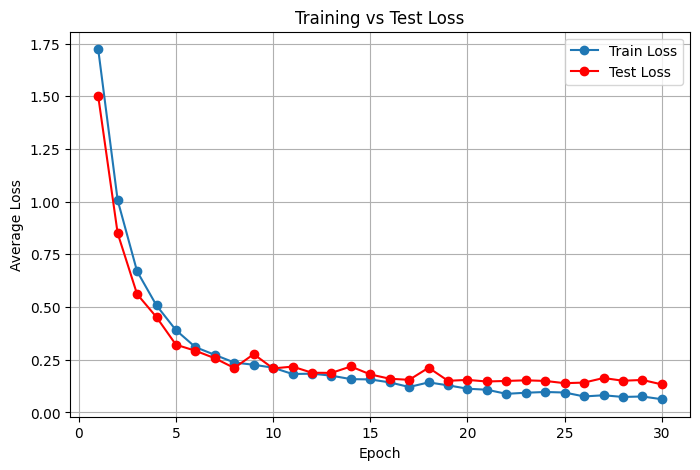

Test Accuracy: 0.9726

 Die ersten N=20 Vorhersagen:

True: Acetaldehyde, Predicted: Acetaldehyde
True: Ethanol, Predicted: Ethanol
True: Acetaldehyde, Predicted: Acetaldehyde
True: Toluene, Predicted: Toluene
True: Acetaldehyde, Predicted: Acetaldehyde
True: Ethanol, Predicted: Ethanol
True: Ammonia, Predicted: Ammonia
True: Ethanol, Predicted: Ethanol
True: Acetaldehyde, Predicted: Acetaldehyde
True: Acetone, Predicted: Acetone
True: Toluene, Predicted: Toluene
True: Acetaldehyde, Predicted: Acetaldehyde
True: Ammonia, Predicted: Ammonia
True: Ammonia, Predicted: Ammonia
True: Acetaldehyde, Predicted: Acetaldehyde
True: Acetone, Predicted: Acetaldehyde
True: Ethanol, Predicted: Ethanol
True: Acetone, Predicted: Acetone
True: Ethanol, Predicted: Ethanol
True: Acetaldehyde, Predicted: Acetaldehyde


In [6]:
# Training starten (Ich empfehle CUDA, auf der CPU wird es mehr Zeit verbrauchen)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTM(input_size=128, hidden_size=256, num_layers=3, num_classes=6, lr=0.0005)
model.to(device)

model.train_model(train_loader, test_loader, epochs=30)
model.evaluate(test_loader)


# Vorhersagen der Gasarten unten
gas_labels = ["Ammonia", "Acetaldehyde", "Acetone", "Ethylene", "Ethanol", "Toluene"]


model.eval()

all_preds = [] # Vorhersagen
all_labels = [] # Echte labels

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs, _ = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

classifications = 20    # Kann größer/kleiner gesetzt werden, je nachdem wie man es will
print(f"\n Die ersten N={classifications} Vorhersagen:\n")

for true_idx, pred_idx in zip (all_labels[:classifications], all_preds[:classifications]):
    print(f"True: {gas_labels[true_idx]}, Predicted: {gas_labels[pred_idx]}")


model.save_model("lstm.pth")

Berechneter Threshold: 17.1882



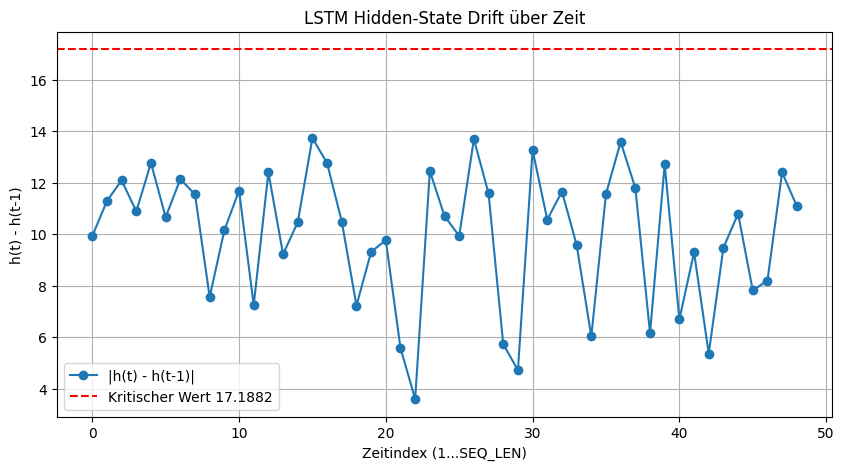


Kein kritisches Verhalten erkannt.


In [7]:
# Hidden-State Driftanalyse Visualisierung
sample_seq = X_test_seq[100]
diffs, critical = analyze_hidden_drift(model, sample_seq, device)

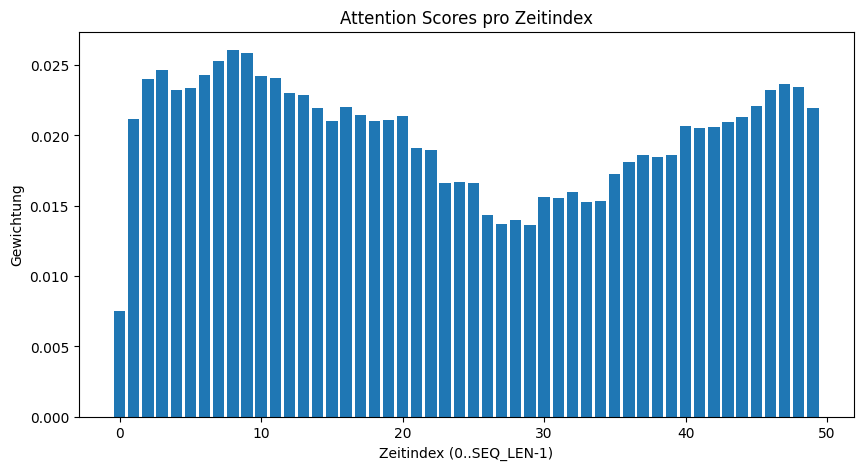

In [8]:
# Attention-Scores Visualisierung
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        _, attn_weights = model(X_batch)
        avg_attn = attn_weights.mean(dim=0).cpu().numpy()

        plt.figure(figsize=(10, 5))
        plt.bar(range(len(avg_attn)), avg_attn)
        plt.title("Attention Scores pro Zeitindex")
        plt.xlabel("Zeitindex (0..SEQ_LEN-1)")
        plt.ylabel("Gewichtung")
        plt.show()
        break

Using device: cuda

--- Fold 1/5 ---
Epoch [1/30] | Train Loss: 1.2530 | Test Loss: 2.2022
Epoch [2/30] | Train Loss: 1.0763 | Test Loss: 0.8791
Epoch [3/30] | Train Loss: 0.7989 | Test Loss: 0.7522
Epoch [4/30] | Train Loss: 0.6716 | Test Loss: 0.5782
Epoch [5/30] | Train Loss: 0.8768 | Test Loss: 1.3852
Epoch [6/30] | Train Loss: 0.7768 | Test Loss: 0.5478
Epoch [7/30] | Train Loss: 0.4570 | Test Loss: 0.4147
Epoch [8/30] | Train Loss: 0.4016 | Test Loss: 0.3235
Epoch [9/30] | Train Loss: 0.2277 | Test Loss: 0.2152
Epoch [10/30] | Train Loss: 0.1562 | Test Loss: 0.1599
Epoch [11/30] | Train Loss: 0.2133 | Test Loss: 0.1346
Epoch [12/30] | Train Loss: 0.1185 | Test Loss: 0.0976
Epoch [13/30] | Train Loss: 0.0981 | Test Loss: 0.0793
Epoch [14/30] | Train Loss: 0.1416 | Test Loss: 0.1099
Epoch [15/30] | Train Loss: 0.0716 | Test Loss: 0.0802
Epoch [16/30] | Train Loss: 0.0725 | Test Loss: 0.0621
Epoch [17/30] | Train Loss: 0.0569 | Test Loss: 0.0696
Epoch [18/30] | Train Loss: 0.0531 | 

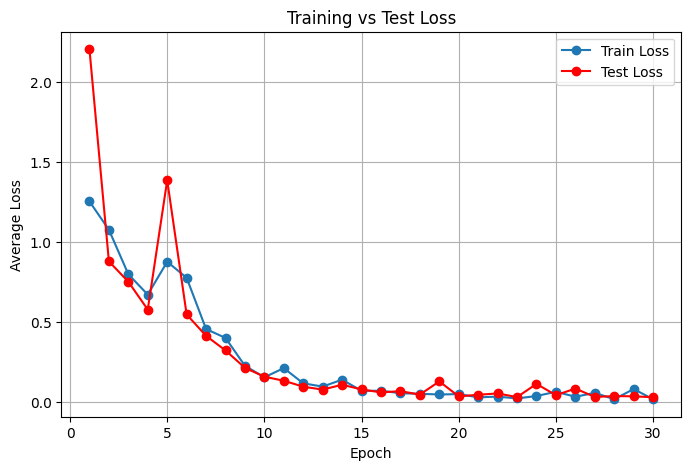

Test Accuracy: 0.9921

--- Fold 2/5 ---
Epoch [1/30] | Train Loss: 1.2875 | Test Loss: 1.0404
Epoch [2/30] | Train Loss: 0.9764 | Test Loss: 0.9527
Epoch [3/30] | Train Loss: 0.8788 | Test Loss: 0.9731
Epoch [4/30] | Train Loss: 0.7989 | Test Loss: 0.5979
Epoch [5/30] | Train Loss: 0.5142 | Test Loss: 0.4466
Epoch [6/30] | Train Loss: 0.3190 | Test Loss: 0.2570
Epoch [7/30] | Train Loss: 0.2388 | Test Loss: 0.2417
Epoch [8/30] | Train Loss: 0.1442 | Test Loss: 0.1712
Epoch [9/30] | Train Loss: 0.1380 | Test Loss: 0.1129
Epoch [10/30] | Train Loss: 0.0971 | Test Loss: 0.1004
Epoch [11/30] | Train Loss: 0.1482 | Test Loss: 0.1195
Epoch [12/30] | Train Loss: 0.0695 | Test Loss: 0.0813
Epoch [13/30] | Train Loss: 0.0562 | Test Loss: 0.1212
Epoch [14/30] | Train Loss: 0.2378 | Test Loss: 0.1769
Epoch [15/30] | Train Loss: 0.0951 | Test Loss: 0.1131
Epoch [16/30] | Train Loss: 0.0545 | Test Loss: 0.0982
Epoch [17/30] | Train Loss: 0.0650 | Test Loss: 0.0759
Epoch [18/30] | Train Loss: 0.0440

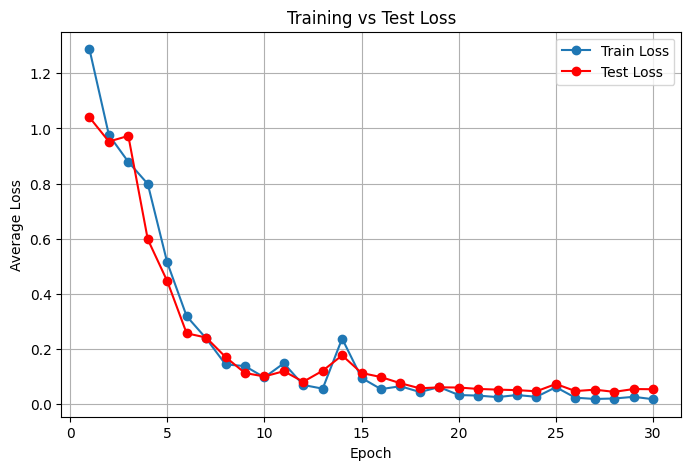

Test Accuracy: 0.9863

--- Fold 3/5 ---
Epoch [1/30] | Train Loss: 1.3129 | Test Loss: 1.0872
Epoch [2/30] | Train Loss: 0.9766 | Test Loss: 0.9074
Epoch [3/30] | Train Loss: 0.8532 | Test Loss: 0.6566
Epoch [4/30] | Train Loss: 0.6667 | Test Loss: 0.6447
Epoch [5/30] | Train Loss: 0.4871 | Test Loss: 0.4279
Epoch [6/30] | Train Loss: 0.3067 | Test Loss: 0.1898
Epoch [7/30] | Train Loss: 0.1773 | Test Loss: 0.1187
Epoch [8/30] | Train Loss: 0.1707 | Test Loss: 0.1047
Epoch [9/30] | Train Loss: 0.1286 | Test Loss: 0.1003
Epoch [10/30] | Train Loss: 0.0865 | Test Loss: 0.0824
Epoch [11/30] | Train Loss: 0.0881 | Test Loss: 0.0744
Epoch [12/30] | Train Loss: 0.1295 | Test Loss: 0.0634
Epoch [13/30] | Train Loss: 0.0574 | Test Loss: 0.0629
Epoch [14/30] | Train Loss: 0.0505 | Test Loss: 0.0476
Epoch [15/30] | Train Loss: 0.1218 | Test Loss: 0.1570
Epoch [16/30] | Train Loss: 0.0808 | Test Loss: 0.0575
Epoch [17/30] | Train Loss: 0.0435 | Test Loss: 0.0514
Epoch [18/30] | Train Loss: 0.0474

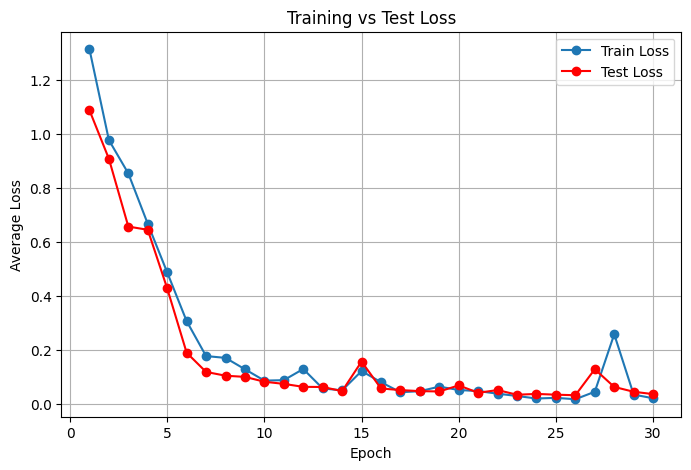

Test Accuracy: 0.9899

--- Fold 4/5 ---
Epoch [1/30] | Train Loss: 1.2978 | Test Loss: 1.0804
Epoch [2/30] | Train Loss: 0.9873 | Test Loss: 0.8767
Epoch [3/30] | Train Loss: 0.8150 | Test Loss: 0.7355
Epoch [4/30] | Train Loss: 0.6258 | Test Loss: 0.5132
Epoch [5/30] | Train Loss: 0.4281 | Test Loss: 0.3358
Epoch [6/30] | Train Loss: 0.2743 | Test Loss: 0.2013
Epoch [7/30] | Train Loss: 0.1619 | Test Loss: 0.1314
Epoch [8/30] | Train Loss: 0.1635 | Test Loss: 0.1107
Epoch [9/30] | Train Loss: 0.1041 | Test Loss: 0.1063
Epoch [10/30] | Train Loss: 0.1878 | Test Loss: 0.1966
Epoch [11/30] | Train Loss: 0.1092 | Test Loss: 0.1327
Epoch [12/30] | Train Loss: 0.0947 | Test Loss: 0.0703
Epoch [13/30] | Train Loss: 0.0553 | Test Loss: 0.0757
Epoch [14/30] | Train Loss: 0.0469 | Test Loss: 0.0546
Epoch [15/30] | Train Loss: 0.0861 | Test Loss: 0.0705
Epoch [16/30] | Train Loss: 0.0394 | Test Loss: 0.0612
Epoch [17/30] | Train Loss: 0.0449 | Test Loss: 0.0811
Epoch [18/30] | Train Loss: 0.0358

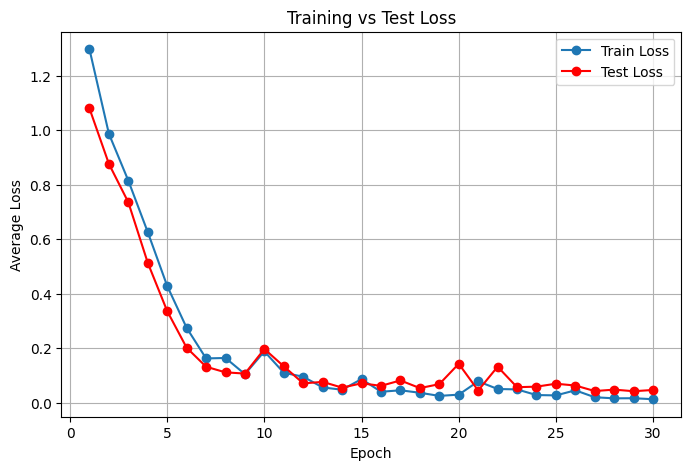

Test Accuracy: 0.9874

--- Fold 5/5 ---
Epoch [1/30] | Train Loss: 1.2655 | Test Loss: 1.1610
Epoch [2/30] | Train Loss: 0.9679 | Test Loss: 1.1869
Epoch [3/30] | Train Loss: 0.8666 | Test Loss: 0.7953
Epoch [4/30] | Train Loss: 0.6988 | Test Loss: 0.6758
Epoch [5/30] | Train Loss: 0.4804 | Test Loss: 0.6158
Epoch [6/30] | Train Loss: 0.3997 | Test Loss: 0.2880
Epoch [7/30] | Train Loss: 0.2773 | Test Loss: 0.1838
Epoch [8/30] | Train Loss: 0.1492 | Test Loss: 0.2123
Epoch [9/30] | Train Loss: 0.1689 | Test Loss: 0.2665
Epoch [10/30] | Train Loss: 0.1239 | Test Loss: 0.0820
Epoch [11/30] | Train Loss: 0.0930 | Test Loss: 0.0695
Epoch [12/30] | Train Loss: 0.0610 | Test Loss: 0.0561
Epoch [13/30] | Train Loss: 0.0877 | Test Loss: 0.0601
Epoch [14/30] | Train Loss: 0.0511 | Test Loss: 0.1023
Epoch [15/30] | Train Loss: 0.0546 | Test Loss: 0.0503
Epoch [16/30] | Train Loss: 0.0389 | Test Loss: 0.0460
Epoch [17/30] | Train Loss: 0.0379 | Test Loss: 0.0845
Epoch [18/30] | Train Loss: 0.1145

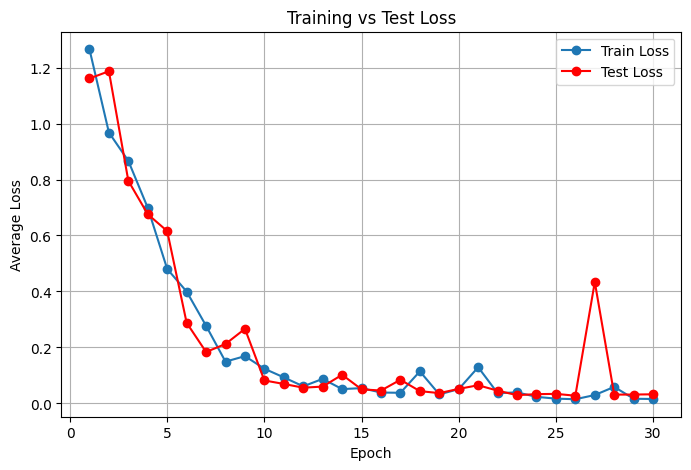

Test Accuracy: 0.9917

Average Validation Accuracy across 5 folds: 0.9895


In [9]:
# 5-Fold Crossvalidation (Bitte Zeit mitnehmen, falls Sie CPU nutzen und diese Zelle ausführen möchten)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Sequenzen einmal erstellen
X_seq, y_seq = create_sequences(X, y - 1, SEQ_LEN)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq)):
    print(f"\n--- Fold {fold+1}/5 ---")
    
    # Fold-Daten
    X_train_fold, y_train_fold = X_seq[train_idx], y_seq[train_idx]
    X_val_fold, y_val_fold = X_seq[val_idx], y_seq[val_idx]
    
    train_dataset = GasSensorDataset(X_train_fold, y_train_fold)
    val_dataset = GasSensorDataset(X_val_fold, y_val_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    model = LSTM(input_size=128, hidden_size=256, num_layers=3, num_classes=6, lr=0.0005)
    model.to(device)
    
    model.optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    
    model.train_model(train_loader, val_loader, epochs=30)
    
    acc = model.evaluate(val_loader)
    fold_accuracies.append(acc)

# Gibt den mean der folds aus
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Validation Accuracy across 5 folds: {avg_acc:.4f}")

In [ ]:
# GRID SEARCH (Bereits durchgeführt - vollstängigkeitshalber aber hier zu sehen) 
# Beste Parameter: hidden_size=256, num_layers=3

# Nach Absprache mussten diese Hyperparameter getestet werden 
param = {
    "hidden_size": [16, 32, 64, 128, 256],
    "num_layers": [1, 2, 3]
}

# Bildet das Kreuzprodukt 
param_combi = list(product(
    param["hidden_size"],
    param["num_layers"]
))

results = []

for hidden_size, num_layers in param_combi:
    print(f"\nTesting params: hidden_size={hidden_size}, num_layers={num_layers}")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, num_classes=6, lr=0.0005)
    model.train_model(train_loader, test_loader, epochs=30)

    acc = model.evaluate(test_loader)
    results.append((hidden_size, num_layers, acc))

# letztlich, wird auf die accuracy aller Elemente geschaut und die beste Kombi ausgegeben
best = max(results, key=lambda x: x[-1])
print("\nBeste Hyperparameter-Kombination:", best)